In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('FB', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2022-03-01,211.750000,202.220001,209.869995,203.490005,27094900,203.490005
2022-03-02,209.149994,202.020004,204.779999,208.110001,29452100,208.110001
2022-03-03,209.080002,201.419998,209.020004,202.970001,27263500,202.970001


In [3]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.81)
training_data_len

1998

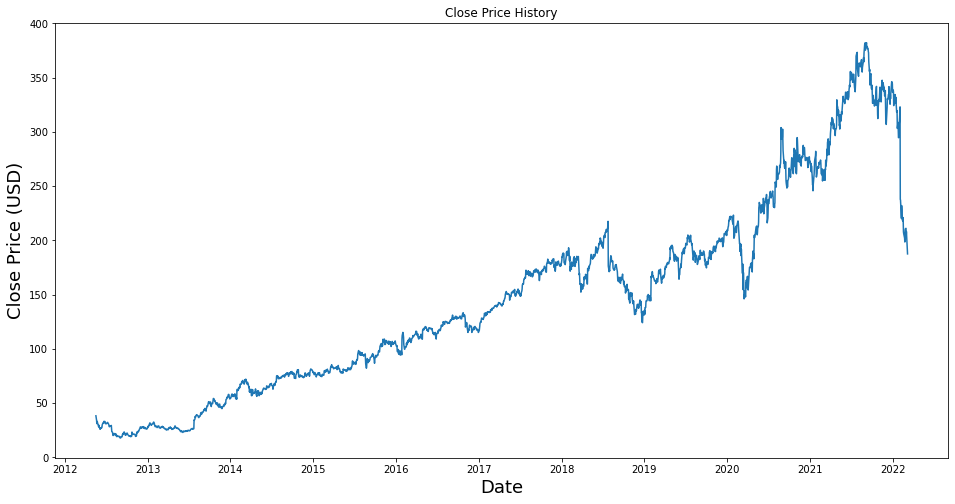

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05624914],
       [0.04472493],
       [0.03641103],
       ...,
       [0.50827275],
       [0.50028811],
       [0.46574291]])

In [6]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.05624914, 0.04472493, 0.03641103, 0.03915489, 0.04198107,
       0.03890795, 0.03048429, 0.02870079, 0.03256963, 0.02741117,
       0.0251612 , 0.02233503, 0.02491425, 0.02354232, 0.02570998,
       0.02546303, 0.02653313, 0.02617643, 0.02897517, 0.03369461,
       0.03753601, 0.03890795, 0.03805735, 0.03871588, 0.04203594,
       0.03931953, 0.04217314, 0.03978598, 0.03739882, 0.03668542,
       0.03577995, 0.03695981, 0.03770064, 0.03841405, 0.03962134,
       0.03770064, 0.03632871, 0.0358897 , 0.03564275, 0.02886542,
       0.0284264 , 0.03122514, 0.03092331, 0.03026479, 0.03023735,
       0.02941419, 0.03185622, 0.02502401, 0.01640829, 0.01487173,
       0.01092056, 0.00864316, 0.00633832, 0.00921937, 0.01149678,
       0.00820414, 0.00820414, 0.00899986, 0.01119495, 0.01061874])]
[0.007271229711778966]



In [7]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1938, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1938/1938 [==============================] - 37s 18ms/step - loss: 7.8941e-04


In [12]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.3524236108502771

C:\Users\kapoo\AppData\Local\Temp/ipykernel_16176/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


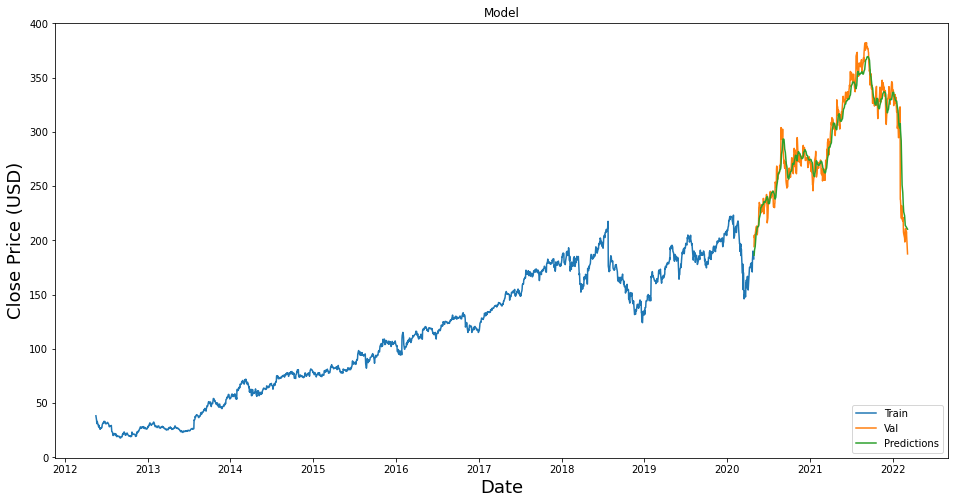

In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [18]:
valid

,Close,Predictions
Date,,
2020-04-29,194.190002,186.228683
2020-04-30,204.710007,188.039474
2020-05-01,202.270004,191.079285
2020-05-04,205.259995,194.187027
2020-05-05,207.070007,197.356628
...,...,...
2022-03-01,203.490005,212.507294
2022-03-02,208.110001,211.934204
2022-03-03,202.970001,211.753128


In [23]:
fb_quote = web.DataReader('FB', data_source='yahoo',start='2012-01-01', end='2022-03-07')
new_df = fb_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[207.89514]]


In [24]:
fb_quote2 = web.DataReader('FB', data_source='yahoo',start='2022-03-01', end='2022-03-07')
print(fb_quote2['Close'])

Date
2022-02-28    211.029999
2022-03-01    203.490005
2022-03-02    208.110001
2022-03-03    202.970001
2022-03-04    200.059998
2022-03-07    187.470001
Name: Close, dtype: float64
